In [54]:
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import reverse_complement
from Bio.SeqUtils import GC

## Load existing readouts

In [9]:
import pandas as pd
import numpy as np
import os, sys
from tqdm.notebook import tqdm

readout_folder = r'/lab/solexa_weissman/puzheng/References/Readouts'
existing_readout_df = pd.read_excel(os.path.join(readout_folder, 'Chromatin_Libraries.xlsx'), 'Readouts')

In [4]:
# import count-table
from importlib import reload
# this version doesn't have ChromAn compiled, so directly load from src:
#sys.path.append(r"/home/puzheng/Softwares")
import MERFISH_probe_design.probe_design.OTTable_dict as ot

readout_seqs = [_s for _s in existing_readout_df['Sequence'] if isinstance(_s, str)]
readout_seqs_rc = [reverse_complement(_s) for _s in readout_seqs]

readout_keylen = 15
readout_table = ot.get_OTTable_for_sequences(readout_seqs + readout_seqs_rc,
                             readout_keylen, verbose=True)

Processed 1000/3658 sequences.
Processed 2000/3658 sequences.
Processed 3000/3658 sequences.


In [20]:
# this version doesn't have ChromAn compiled, so directly load from src:
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares/ChromAn")
import src
reload(src)

<module 'src' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/__init__.py'>

# Download 24,000 orthogonal 25mer sequences used to design NDBs:
https://elledge.hms.harvard.edu/?page_id=638

https://www.pnas.org/doi/abs/10.1073/pnas.0812506106


In [5]:

bc25mer_filename = os.path.join(readout_folder, 'bc25mer.240k.fasta')

barcodes = []

with open(bc25mer_filename, 'r') as _handle:
    for _record in SeqIO.parse(_handle, "fasta"):
        barcodes.append(_record)
print(len(barcodes))

240000



## Acoording to previous records, I used ~ first 6000 to generate NDB readouts

Therefore, I will start from the middle:

In [7]:
# T7, T3, T3ext, PacIsite
upstream_seq = 'cgcctccccgcatcgatacctaatacgactcactatagggagagtaattaaccctcactaaagggataatttaattaa' 
# 120nt MERFISH intBC here:

# sequencing primer in the middle:
primer_10x = 'gaatccagctagctgtgcagc'
# 30nt intBC here:

# PacI site again, RNF2 full casette
downstream_seq = 'ttaattaatggcagtcatcttagtcattacgacaggtgttcgttgtaactcatata'

# masked sequences:
masked_seqs = ['AAAAA', 'CCCCC', 'GGGGG', 'TTTTT', 'ttaattaa']

In [11]:
readout_table

{'ATCCTCCTTCAATAC': 1,
 'TCCTCCTTCAATACA': 1,
 'CCTCCTTCAATACAT': 1,
 'CTCCTTCAATACATC': 1,
 'TCCTTCAATACATCC': 1,
 'CCTTCAATACATCCC': 1,
 'ACACTACCACCATTT': 1,
 'CACTACCACCATTTC': 1,
 'ACTACCACCATTTCC': 1,
 'CTACCACCATTTCCT': 1,
 'TACCACCATTTCCTA': 1,
 'ACCACCATTTCCTAT': 1,
 'ACTCCACTACTACTC': 1,
 'CTCCACTACTACTCA': 1,
 'TCCACTACTACTCAC': 1,
 'CCACTACTACTCACT': 1,
 'CACTACTACTCACTC': 1,
 'ACTACTACTCACTCT': 1,
 'ACCCTCTAACTTCCA': 1,
 'CCCTCTAACTTCCAT': 1,
 'CCTCTAACTTCCATC': 1,
 'CTCTAACTTCCATCA': 1,
 'TCTAACTTCCATCAC': 1,
 'CTAACTTCCATCACA': 1,
 'ACCACAACCCATTCC': 1,
 'CCACAACCCATTCCT': 1,
 'CACAACCCATTCCTT': 1,
 'ACAACCCATTCCTTT': 1,
 'CAACCCATTCCTTTC': 1,
 'AACCCATTCCTTTCA': 1,
 'TTTCTACCACTAATC': 1,
 'TTCTACCACTAATCA': 1,
 'TCTACCACTAATCAA': 1,
 'CTACCACTAATCAAC': 1,
 'TACCACTAATCAACC': 1,
 'ACCACTAATCAACCC': 1,
 'ACCCTTTACAAACAC': 1,
 'CCCTTTACAAACACA': 1,
 'CCTTTACAAACACAC': 1,
 'CTTTACAAACACACC': 1,
 'TTTACAAACACACCC': 1,
 'TTACAAACACACCCT': 1,
 'TCCTATTCTCAACCT': 1,
 'CCTATTCTC

## Predict self-binding and save candidate intBCs

In [123]:
from nupack import pfunc
final_seqs = []
buffer_seqs = []

readout_counts, final_dGs = [], []

crosstalk_keylen = 15
crosstalk_table = ot.OTTable()

num_trial = 15
model1 = Model(material='rna', celsius=37, sodium=0.39)

# generate full length based on barcodes
for _b in tqdm(barcodes[180000:]):
    # for each of barcode, check with existing readouts
    _seq = str(_b.seq)
    _count = np.sum([readout_table[_seq[_i:_i+readout_keylen]] 
                     for _i in range(0, len(_seq)-readout_keylen+1)])
    _cross_count = np.sum([crosstalk_table[_seq[_i:_i+readout_keylen]] 
                           for _i in range(0, len(_seq)-readout_keylen+1)])
    readout_counts.append(_count)
    if _count or _cross_count:
        #print(_count, _cross_count)
        continue
    else:
        buffer_seqs.append(_seq)
    # cleanup
    if len(buffer_seqs) == 10:
        _trial = 0
        _current_dG = - np.inf
        
        while _trial < num_trial:
            # randomly concat barcodes
            _concat_seq = ''.join(list(np.random.permutation(buffer_seqs[-10:])))
            # generate sequences
            _cand_seq = upstream_seq + _concat_seq[:210] + primer_10x + _concat_seq[210:240] + downstream_seq
            _final_readout_count = np.sum([readout_table[_seq[_i:_i+readout_keylen]] 
                                   for _i in range(0, len(_cand_seq)-readout_keylen+1)])
            _final_cross_count = np.sum([crosstalk_table[_seq[_i:_i+readout_keylen]] 
                                         for _i in range(0, len(_cand_seq)-readout_keylen+1)])
            # if no crosstalk, calculate energy:
            if _final_readout_count == 0 and _final_cross_count == 0 \
            and not np.any([_s.upper() in _cand_seq.upper() for _s in masked_seqs[:-1]]):
                _test_strand = Strand(_cand_seq.upper(), name='test')
                _cand_dG = pfunc(strands=[_test_strand, _test_strand], model=model1)[1]
                if _cand_dG > _current_dG:
                    _final_seq = _cand_seq
                    _current_dG = _cand_dG
                    #print('change')
            # update
            _trial += 1
            #print(_trial)
        # final append
        final_seqs.append(_final_seq)
        final_dGs.append(_current_dG)
        #print(len(final_seqs))
        # append
        for _j in range(0, len(_final_seq) - crosstalk_keylen + 1):
            _seq_fragment = _final_seq[_j:_j+crosstalk_keylen]
            crosstalk_table.add_seq(_seq_fragment, 1)
            crosstalk_table.add_seq(reverse_complement(_seq_fragment), 1)
        # clean up
        buffer_seqs = []
#
print(len(final_seqs))

  0%|          | 0/60000 [00:00<?, ?it/s]

5970


## Save

In [126]:
# save these candidate sequences:
probe_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS'
save_folder = os.path.join(probe_folder, 'RandomSeqBarcode_new')
save_separate_folder = os.path.join(save_folder, 'TargetProbe_separate')
# create 
from src.file_io.data_organization import create_folder
from src.parallel_tools.process_io import time_full

create_folder(save_folder)
create_folder(save_separate_folder)

Folder: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new already exists
Creating folder: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new/TargetProbe_separate


In [125]:
import pandas as pd
overwrite = True
final_seq_df = pd.DataFrame({'Sequence':final_seqs})
candidate_seq_filename = os.path.join(save_folder, 'candidate_fullseqs.xlsx')
if not os.path.exists(candidate_seq_filename) or overwrite:
    print(candidate_seq_filename)
    final_seq_df.to_excel(candidate_seq_filename, index=None)

/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new/candidate_fullseqs.xlsx


## save by target

In [128]:
import re
final_probes = []
probe_len = 30

for _seq in final_seqs:
    _upper_seqs = re.split( r'[atgc]+', _seq)
    _probes = [reverse_complement(_upper_seqs[1][probe_len*_i:probe_len*(_i+1)]) 
               for _i in range(int(len(_upper_seqs[1])/probe_len))]
    _probes.append(reverse_complement(_upper_seqs[2][-probe_len:]))
    final_probes.append(_probes)
probe_df_list = []
for _i, (_target, _probes) in enumerate(zip(final_seqs, final_probes)):
    _pb_df = pd.DataFrame({'Name':[f"Target-{_i}"]+[f"Target-{_i}_pb-{_j}" for _j in range(len(_probes))],
                           'Sequence':[_target]+_probes,})
    
    _pb_filename = os.path.join(save_separate_folder, f'targetPb_{_i}.xlsx')
    _pb_df.to_excel(_pb_filename, index=None)

## Example script to predict cross-hybridization by Nupack

In [24]:
import pandas as pd
from nupack import Strand, Tube, SetSpec, Model, tube_analysis

if __name__ == "__main__":
    
    print(f"Start job at: {time_full()}")
    
    input_seq_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode/candidate_fullseqs.xlsx'
    input_seq_num = 10
    
    output_filename = os.path.join(r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode',
                                   f"new_run_{input_seq_num}_candSeqs.txt")

    input_seq_df = pd.read_excel(input_seq_filename)
    
    test_strands = []

    for _i, _seq in enumerate(input_seq_df['Sequence'][:input_seq_num]):
        test_strands.append(Strand(_seq.upper(), name=f's{_i}'),)
    
    print(f"- {len(test_strands)} sequences loaded.")
    
    t1 = Tube(strands={_s:1e-9 for _s in test_strands}, 
          complexes=SetSpec(max_size=2),
          name='tube')
    print(f"- analyzing tubes")
    # analyze tubes
    model1 = Model(material='rna', celsius=40, sodium=0.39)
    tube_results = tube_analysis(tubes=[t1], model=model1,
                                 compute=['pairs'], #'mfe', 'sample', 'ensemble_size'],
                                 #options={'num_sample': 100},
                                )
    print(f"- saving result to file: {output_filename}")
    tube_results.save_text(output_filename)
    
    print(f"End job at: {time_full()}")

Start job at: 2023/3/20, 22:48:13
- 10 sequences loaded.
- analyzing tubes
- saving result to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode/new_run_10_candSeqs.txt
End job at: 2023/3/20, 22:48:35


# For these 10k sequences, screen with Nupack

In [183]:
from nupack import Strand, Tube, SetSpec, Domain, TargetStrand, TargetComplex

In [580]:
%%time
test_strands = []

for _i, _seq in enumerate(final_seqs[:100]):
    test_strands.append(Strand(_seq.upper(), name=f'target_{_i}'),)
    
t1 = Tube(strands={_s:1e-8 for _s in test_strands[:10]}, 
          complexes=SetSpec(max_size=2),
          name='t1')
# analyze tubes
model1 = Model(material='rna', celsius=40)
tube_results = tube_analysis(tubes=[t1], model=model1,
                             compute=['pairs', 'pfunc'],
                             #compute=['pairs', 'mfe', 'sample', 'ensemble_size'],
                             #options={'num_sample': 100},
                            )

KeyboardInterrupt: 

In [341]:
%%time
set1 = ComplexSet(strands=test_strands[:10], complexes=SetSpec(max_size=2))
model1 = Model(material='rna', celsius=23)
complex_results1 = complex_analysis(complexes=set1, model=model1, compute=['pfunc'])

CPU times: user 2min 49s, sys: 1.86 s, total: 2min 51s
Wall time: 21.5 s


In [334]:
tube_results[t1].fraction_bases_unpaired

0.3886987195601726

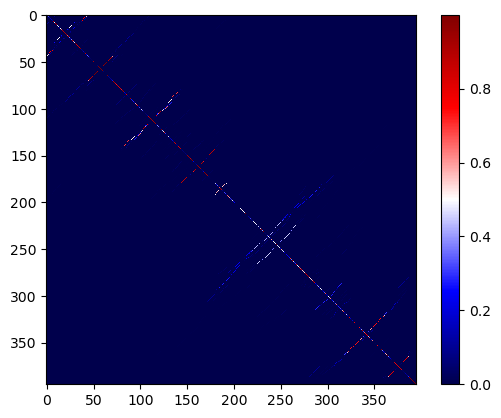

In [346]:
sel_id = 9

plt.imshow(tube_results[t1].ensemble_pair_fractions.to_array()[395*sel_id:395*(sel_id+1)][:,395*sel_id:395*(sel_id+1)], 
           interpolation='nearest', cmap='seismic')
plt.colorbar()
plt.show()

In [579]:
0.65*30 + 22

41.5

default setting:
10: 21s
20: 84s 
add structural:
10: 102 s

In [617]:
! python
exit()

Python 3.6.9 (default, Feb 28 2023, 09:55:20) 
[GCC 8.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyboardInterrupt
>>> 

In [327]:
%%time
model1 = Model(material='rna', celsius=40, sodium=0.39)
sel_pair = [1,1]

# load two sets of targets and tubes
targets = []
probes = []
for _id in sel_pair:
    _pbdf = pd.read_excel(os.path.join(save_separate_folder, f'targetPb_{_id}.xlsx'))
    _strands = [Strand(_s.upper(), name=_n) for _i, (_n, _s) in _pbdf.iterrows()]
    targets.append(_strands[0])
    probes.extend(_strands[1:])
# init tube

tbs = [
    Tube(strands={targets[0]:1e-9, targets[1]:1e-9, _p:10e-9}, complexes=SetSpec(max_size=2),
         name=f"tube-{sel_pair[0]}-{sel_pair[1]}_pb-{_j}") for _j, _p in enumerate(probes)
]

print("Start tube analysis")
# analyze tubes
tube_results = tube_analysis(tubes=tbs, model=model1,
                             compute=['pairs', 'pfunc',],
                             #compute=['pairs', 'mfe', 'sample', 'ensemble_size'],
                             #options={'num_sample': 100},
                            )

Start tube analysis
CPU times: user 16.6 s, sys: 902 ms, total: 17.5 s
Wall time: 2.5 s


In [328]:
ensemble_pair_matrices = np.array([tube_results[_tb].ensemble_pair_fractions.to_array()
                                   for _tb in tbs], dtype=np.float16)

In [336]:
log_on_off_ratios = []
for _tb in tbs[:]:

    _strand_names = [_s.name for _s in _tb.strands]
    _target_names = _strand_names[:-1]
    _probe_name = _strand_names[-1]
    _probe_target_name = _probe_name.split('_')[0]
    #print(_strand_names)
    on_target_concs, off_target_concs = [], []

    for _complex, _conc in tube_results[_tb].complex_concentrations.items():
        _match = re.search(r'.+\(([a-zA-Z0-9\-\_\+ ]+)\).+', _complex.__str__(), )
        _complex_strands = _match.groups()[0].split('+')

        if _probe_name in _complex_strands and _probe_target_name in _complex_strands:
            on_target_concs.append(_conc)
        elif _probe_name in _complex_strands and _probe_target_name not in _complex_strands and len(np.unique(_complex_strands)) > 1:
            #print(_complex_strands, _conc)
            off_target_concs.append(_conc)
    #print(_strand_names, on_target_concs, off_target_concs)
    if len(on_target_concs)==0 or len(off_target_concs)==0:
        log_on_off_ratios.append(0)
    else:
        log_on_off_ratios.append(np.log(np.sum(off_target_concs) / np.sum(on_target_concs)))
print(log_on_off_ratios)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [326]:
_strand_names

['Target-1', 'Target-2', 'Target-2_pb-7']

In [1]:
output_folder = os.path.join(save_separate_folder, 'outputs')
ix, iy, ratios = [], [], []
for _f in os.listdir(output_folder):
    if re.match(r'test_run_([0-9]+)-([0-9]+)_candSeqs_logRatio.npy', _f):
        _x, _y = re.search(r'test_run_([0-9]+)-([0-9]+)_candSeqs_logRatio.npy', _f).groups()
        _ratios = np.load(os.path.join(output_folder, _f))
        ix.append(int(_x))
        iy.append(int(_y))
        ratios.append(np.mean(_ratios))

NameError: name 'os' is not defined

In [349]:
np.load(r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/RandomSeqBarcode_new/TargetProbe_separate/outputs/test_run_788_logRatio.npy')

array([[-5.08802015e+00, -8.30673087e+00, -1.05553734e+01, ...,
        -7.33015308e+00, -8.52878678e+00, -4.15820636e+00],
       [-5.24053731e+00, -7.88473039e+00, -1.05014630e+01, ...,
        -6.41904454e+00, -8.17947556e+00, -8.83813142e+00],
       [-4.91393490e+00, -7.77144692e+00, -6.25600592e+00, ...,
        -4.52799562e+00, -4.39719327e+00, -8.69200767e+00],
       ...,
       [-6.57962007e+00, -7.93379614e+00, -9.48358128e+00, ...,
        -6.29653900e+00, -7.84933896e+00, -9.65863563e+00],
       [-5.53546204e+00, -6.90614426e+00, -8.66939336e+00, ...,
        -5.70834957e+00, -2.46514986e-04, -7.10508367e+00],
       [-3.24468573e+00, -3.47232366e+00, -8.94393884e+00, ...,
        -8.30597802e+00, -7.46957888e+00, -9.03305629e+00]])

In [338]:
mat = np.zeros([10,10])

In [339]:
mat[np.array(ix), np.array(iy)] = np.array(ratios)

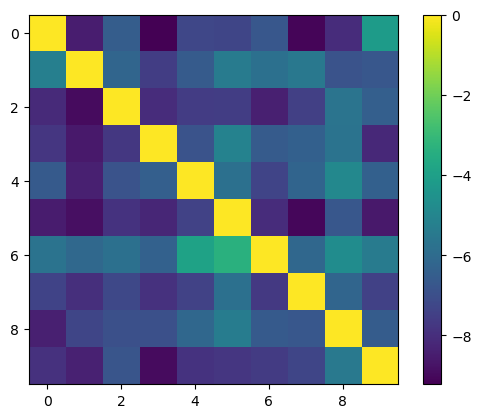

In [340]:
plt.imshow(mat)
plt.colorbar()

In [307]:
np.array(ix)

array(['3', '8', '9', '5', '2', '6', '4', '1', '9', '8', '2', '0', '1',
       '7', '9', '4', '3', '0', '6', '9', '8', '3', '8', '3', '1', '6',
       '3', '9', '1', '2', '8', '5', '0', '4', '0', '1', '6', '4', '7',
       '6', '5', '1', '9', '1', '9', '4', '1', '7', '5', '7', '3', '6',
       '3', '8', '1', '7', '5', '5', '0', '0', '4', '3', '2', '7', '7',
       '6', '2', '4', '5', '5', '6', '0', '6', '4', '2', '4', '1', '9',
       '6', '2', '8', '7', '8', '7', '0', '0', '9', '9', '2', '2', '0',
       '2', '4', '5', '8', '8', '7', '5', '3', '3'], dtype='<U1')

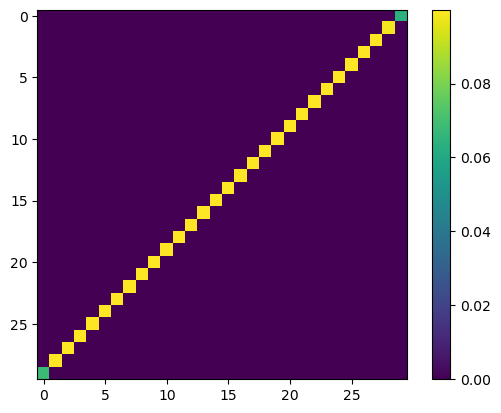

In [238]:
plt.imshow(ensemble_pair_matrices[0][-30:][:,len(upstream_seq):len(upstream_seq)+30])
plt.colorbar()

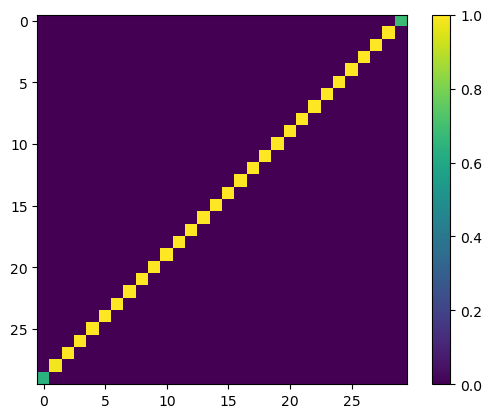

In [239]:
plt.imshow(ensemble_pair_matrices[0][len(upstream_seq):len(upstream_seq)+30][:,-30:])
plt.colorbar()

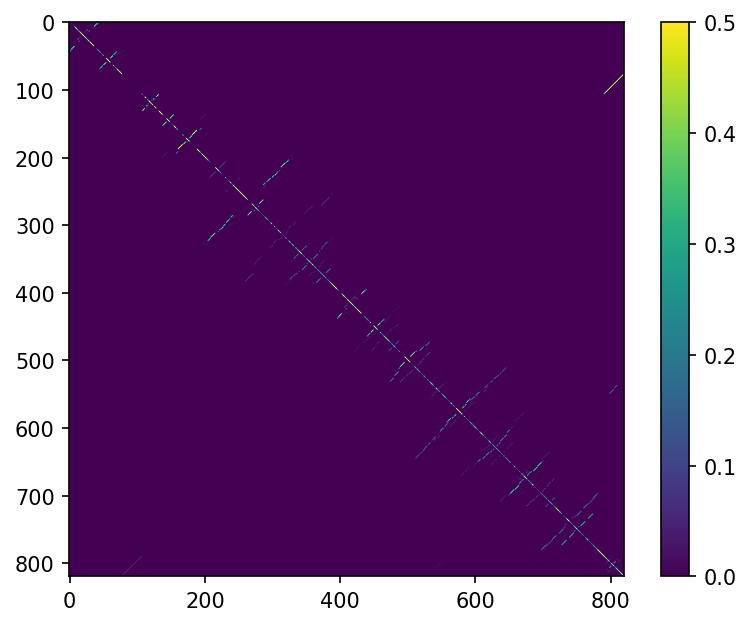

In [240]:
plt.figure(dpi=150)
plt.imshow(ensemble_pair_matrices[0], interpolation=None)
plt.colorbar()
plt.clim([0,0.5])
plt.show()

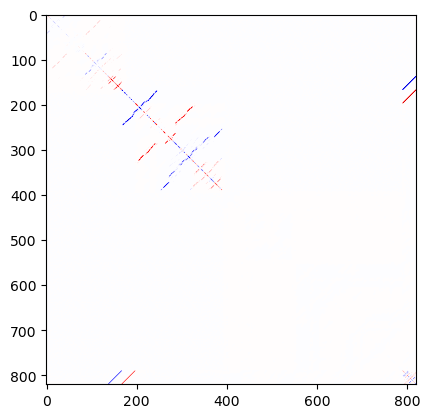

In [206]:
plt.imshow(tube_results[tbs[3]].ensemble_pair_fractions.to_array() - tube_results[tbs[2]].ensemble_pair_fractions.to_array()
           , interpolation=None, cmap='seismic')
plt.clim([-0.5,0.5])

In [141]:
from nupack.analysis import Result

In [142]:

my_result = Result.load(os.path.join(save_separate_folder,'test_run_1-2_candSeqs.o'))

In [143]:
my_result

Complex,Pfunc,ΔG (kcal/mol)
(Target-1),6.2754e+53,-77.084
(Target-1_pb-0),1.8686e+1,-1.822
(Target-1_pb-1),7.9162e+3,-5.586
(Target-1_pb-2),4.8339e+2,-3.846
(Target-1_pb-3),6.8818e+1,-2.633
(Target-1_pb-4),7.6197e+0,-1.264
(Target-1_pb-5),4.2920e+1,-2.339
(Target-1_pb-6),6.7216e+3,-5.484
(Target-1_pb-7),5.4376e+2,-3.919
(Target-2),3.1500e+59,-85.253


In [153]:
_tbs = list(my_result.as_dict()['tubes'])



In [175]:
ensemble_pair_matrices = np.array([my_result[_tb].ensemble_pair_fractions.to_array()
                                   for _tb in _tbs])


In [170]:
my_result[_tbs[0]].complex_concentrations

{<Complex (Target-1_pb-0)>: 8.65627796741158e-09,
 <Complex (Target-1_pb-0+Target-1_pb-0)>: 9.51696902485189e-12,
 <Complex (Target-1_pb-0+Target-1)>: 1.0000000000293691e-09,
 <Complex (Target-1_pb-0+Target-2)>: 3.246880945050378e-10,
 <Complex (Target-1)>: 1.891025795392398e-32,
 <Complex (Target-1+Target-1)>: 4.199978339472206e-58,
 <Complex (Target-1+Target-2)>: 4.8224946564850125e-36,
 <Complex (Target-2)>: 6.746313633870503e-10,
 <Complex (Target-2+Target-2)>: 3.402710672476019e-13}

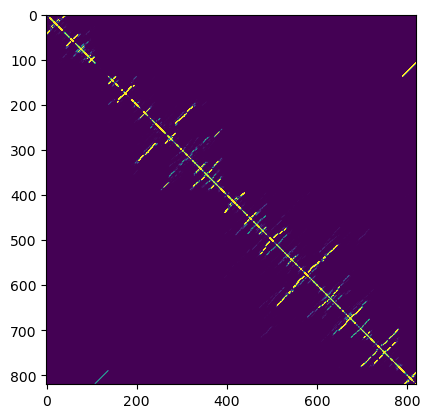

In [177]:
plt.imshow(ensemble_pair_matrices[1], interpolation=None)
plt.clim([0,0.05])

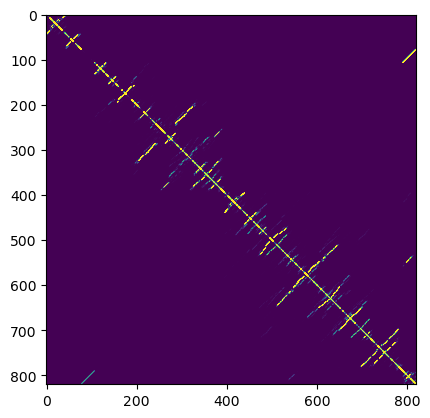

In [176]:
plt.imshow(ensemble_pair_matrices[0], interpolation=None)
plt.clim([0,0.05])

In [605]:
tube_results[tbs[0]].ensemble_pair_fractions.to_array()

matrix([[9.92558190e-01, 2.31174992e-29, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.31174992e-29, 5.57752039e-01, 9.65697417e-28, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.65697417e-28, 5.13980923e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.03057215e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 9.17251340e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 9.64349964e-01]])

In [610]:
tube_results[tbs[1]].complex_concentrations

{<Complex (Target-1_pb-1)>: 8.99875932820294e-09,
 <Complex (Target-1_pb-1+Target-1_pb-1)>: 4.653492279067743e-14,
 <Complex (Target-1_pb-1+Target-2)>: 1.1475954595395855e-12,
 <Complex (Target-1_pb-1+Target-1)>: 1.0000000058409833e-09,
 <Complex (Target-2)>: 7.971828460955779e-10,
 <Complex (Target-2+Target-2)>: 1.008347792228554e-10,
 <Complex (Target-2+Target-1)>: 1.5322641262226477e-29,
 <Complex (Target-1)>: 1.0302927268256469e-25,
 <Complex (Target-1+Target-1)>: 2.255528379251292e-43}

In [585]:
list(tube_results.complexes.keys())[1]

<Complex (Target-2_pb-4+Target-1_pb-0)>

In [562]:
list(tube_results.complexes.values())[0].pairs.to_array().shape

(60, 60)

In [573]:
print(strands[10])

CGCACGGGCCTTGAGTATTATCCCGTAACG


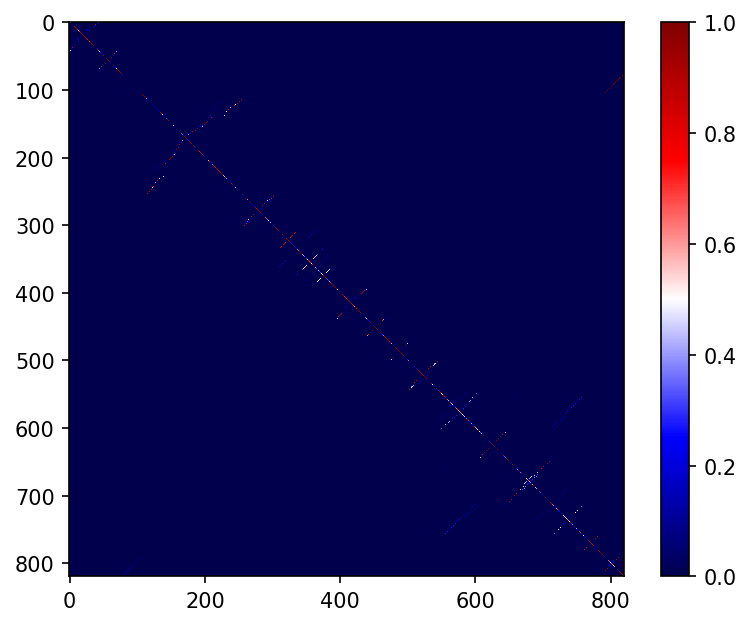

In [606]:
plt.figure(dpi=150)
plt.imshow(tube_results[tbs[0]].ensemble_pair_fractions.to_array(),#list(tube_results.complexes.values())[3].pairs.to_array(), 
           interpolation='nearest', cmap='seismic')
plt.clim([0,1])
plt.colorbar()
plt.show()

In [530]:
target = str(tb.strands[0])
probe = str(tb.strands[1])

In [532]:
reverse_complement(probe) in target

True

In [418]:
tube_results[tb].ensemble_pair_fractions.to_array()

matrix([[9.93425001e-01, 5.96695817e-58, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 3.11356826e-35],
        [5.96695817e-58, 4.20648699e-01, 6.05286587e-56, ...,
         0.00000000e+00, 8.85257569e-36, 0.00000000e+00],
        [0.00000000e+00, 6.05286587e-56, 3.83448023e-01, ...,
         0.00000000e+00, 0.00000000e+00, 1.95253641e-35],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.94743767e-01, 2.43864810e-07, 0.00000000e+00],
        [0.00000000e+00, 8.85257569e-36, 0.00000000e+00, ...,
         2.43864810e-07, 3.01358261e-01, 3.71559400e-12],
        [3.11356826e-35, 0.00000000e+00, 1.95253641e-35, ...,
         0.00000000e+00, 3.71559400e-12, 4.20779866e-01]])

In [415]:
dir(tube_results[tb])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'complex_concentrations',
 'ensemble_pair_fractions',
 'fraction_bases_unpaired']

In [520]:
A = Strand('A20', name='A20')
B = Strand("T20", name='T20')
C = Strand("G20", name='G20')
cs1 = ComplexSet(strands=[A,B,C], complexes=SetSpec(max_size=3))
t1 = Tube(strands={A:1e-8,B:1e-8,C:1e-8}, name='t1', complexes=SetSpec(max_size=3),)
tube_res = tube_analysis(tubes=[t1], model=model1, compute=['pairs', 'pfunc', 'ensemble_size'],)

In [521]:
print(A)

AAAAAAAAAAAAAAAAAAAA


In [522]:
tube_res

Complex,Pfunc,ΔG (kcal/mol),Ensemble size
(A20),1.0000e+0,0.000,1.000
(G20),1.0000e+0,0.000,1.000
(T20),1.0000e+0,0.000,1.000
(A20+A20),0.0000e+3,inf,0.000
(A20+G20),0.0000e+4,inf,0.000
(A20+T20),9.9287e+13,-18.967,701842305764.000
(G20+G20),0.0000e+3,inf,0.000
(G20+T20),1.0608e+13,-17.651,701842305764.000
(T20+T20),0.0000e+3,inf,0.000
(A20+A20+A20),0.0000e-50,inf,0.000


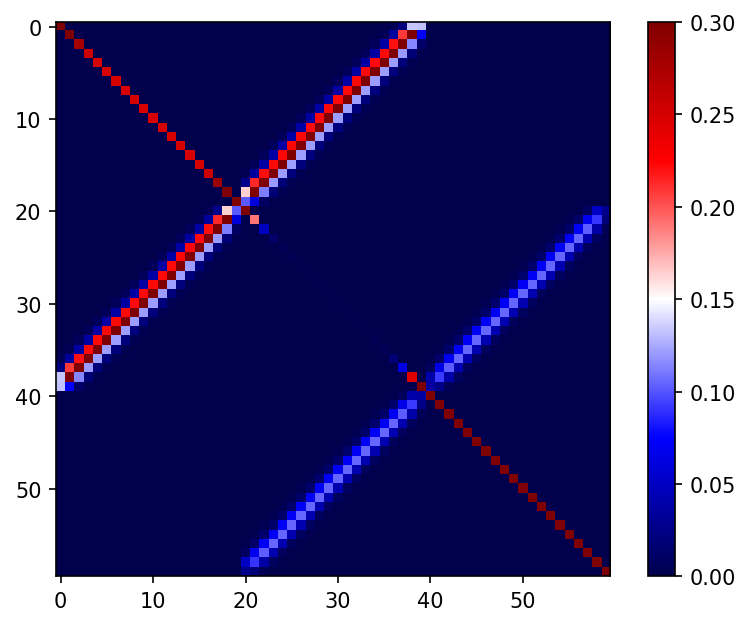

In [523]:
plt.figure(dpi=150)
plt.imshow(tube_res[t1].ensemble_pair_fractions.to_array(), 
           interpolation='nearest', cmap='seismic')
plt.clim([0,0.3])
plt.colorbar()
plt.show()

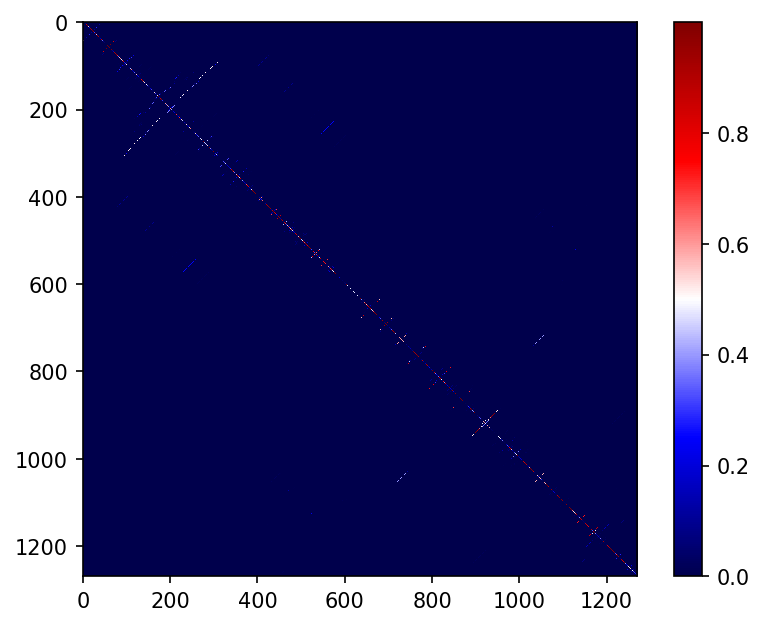

In [412]:
plt.figure(dpi=150)
plt.imshow(tube_results[tb].ensemble_pair_fractions.to_array(), 
           interpolation='nearest', cmap='seismic')
plt.colorbar()
plt.show()

In [ ]:
%%time
test_strands = []

for _i, _seq in enumerate(final_seqs[:100]):
    test_strands.append(Strand(_seq.upper(), name=f'target_{_i}'),)
    
t1 = Tube(strands={_s:1e-8 for _s in test_strands[:10]}, 
          complexes=SetSpec(max_size=2),
          name='t1')
# analyze tubes
model1 = Model(material='rna', celsius=23)
tube_results = tube_analysis(tubes=[t1], model=model1,
                             compute=['pairs', 'pfunc'],
                             #compute=['pairs', 'mfe', 'sample', 'ensemble_size'],
                             #options={'num_sample': 100},
                            )

In [391]:
_pb_df

,Name,Sequence
0,Target-0,cgcctccccgcatcgatacctaatacgactcactatagggagagta...
1,Target-0_pb-0,GACGAACGGCTACTAACTCGCTCCCATGAG
2,Target-0_pb-1,GAATCAGTCATGTTTACTTAGGGGAAATAA
3,Target-0_pb-2,ACCCCTTGCGATATCTGCGGTTTACGGCCA
4,Target-0_pb-3,CCGGGGAGAGCTATCGCAGAAAAGTACCGG
5,Target-0_pb-4,CTGATCAGCGATCGTGATTGGAGTCATTTA
6,Target-0_pb-5,TACAATGCACGAGTAAACGGCTAATACTGT
7,Target-0_pb-6,CGGACCAATCAAACAAAGTGAGCCTGCGAG
8,Target-0_pb-7,TTAGCCAAACATACCGCCTACTCTGCAAAG


In [382]:
_probes

['CTCATGGGAGCGAGTTAGTAGCCGTTCGTC',
 'TTATTTCCCCTAAGTAAACATGACTGATTC',
 'TGGCCGTAAACCGCAGATATCGCAAGGGGT',
 'CCGGTACTTTTCTGCGATAGCTCTCCCCGG',
 'TAAATGACTCCAATCACGATCGCTGATCAG',
 'ACAGTATTAGCCGTTTACTCGTGCATTGTA',
 'CTCGCAGGCTCACTTTGTTTGATTGGTCCG',
 'CTTTGCAGAGTAGGCGGTATGTTTGGCTAA']

In [162]:
C1.strands, C1.nstrands(), C1.nt()

((<TargetStrand target_strand_0>,
  <TargetStrand target_strand_1>,
  <TargetStrand target_strand_2>,
  <TargetStrand target_strand_3>,
  <TargetStrand target_strand_4>,
  <TargetStrand target_strand_5>,
  <TargetStrand target_strand_6>,
  <TargetStrand target_strand_7>,
  <TargetStrand target_strand_8>,
  <TargetStrand target_strand_9>),
 10,
 3950)

Stand 0


In [133]:
len(buffer_seqs)

119396

In [125]:
_concat_seq[210:240]

'TCCCGGAAATAATGG'

In [119]:
_concat_seq[210:240]

'TCCCGGAAATAATGG'

In [73]:
final_seqs[0]

'cgcctccccgcatcgatacctaatacgactcactatagggagagtaattaaccctcactaaagggataatttaattaaTAGCAGCCATCGTGACATATTATGAGGGACTTGTTTGGTCATTTTACCCTTTTTGCGGCGCGTGATCCTCATATTGTTCTCGTGACTCGTTATTCTAGACTAGGGCAACTCCGACATCGATCTGAAAAGGTTCTTTCCGGGGTGTGCGTAGGCTAACGTAACGGGTTGCTGCTTCTACACCGCATCCCTTATAAATGTTGTTGCATCGGTgaatccagctagctgtgcagcATCGGATCCTTCCGAttaattaatggcagtcatcttagtcattacgacaggtgttcgttgtaactcatata'

In [80]:
len(final_seqs)

111537

In [72]:
len(final_seqs)

119984

In [ ]:
# select 8 seqs for the front, 1 seq for the end


In [86]:
nanodrop_folder = r'/lab/solexa_weissman/puzheng/Experiments/NanoDrops/'
exp_filename = os.path.join(nanodrop_folder, '20230318-Luke_minipreps.txt')
exp_df = pd.read_csv(exp_filename, delimiter='\t')

In [97]:
exp_df

,Plate ID,Well,Sample ID,User ID,Date,Time,Conc.,Units,A260,A280,260/280,260/230,Conc. Factor (ng/ul),Cursor Pos.,Cursor abs.,340 raw,NA Type
0,NaN,A1,NaN,Default,3/18/2023,3:56 PM,926.5,ng/ul,18.530,10.057,1.84,2.33,50.0,260,18.487,0.004,DNA-50
1,NaN,B1,NaN,Default,3/18/2023,3:56 PM,585.2,ng/ul,11.704,6.434,1.82,2.30,50.0,260,11.682,0.037,DNA-50
2,NaN,C1,NaN,Default,3/18/2023,3:56 PM,739.3,ng/ul,14.785,8.302,1.78,2.19,50.0,260,14.764,0.013,DNA-50
3,NaN,D1,NaN,Default,3/18/2023,3:56 PM,832.6,ng/ul,16.651,9.222,1.81,2.21,50.0,260,16.623,-0.031,DNA-50
4,NaN,E1,NaN,Default,3/18/2023,3:56 PM,205.6,ng/ul,4.112,2.238,1.84,2.30,50.0,260,4.103,0.037,DNA-50
5,NaN,F1,NaN,Default,3/18/2023,3:56 PM,866.3,ng/ul,17.325,9.535,1.82,2.31,50.0,260,17.274,0.001,DNA-50
6,NaN,G1,NaN,Default,3/18/2023,3:56 PM,518.3,ng/ul,10.367,5.667,1.83,2.25,50.0,260,10.348,0.003,DNA-50
7,NaN,H1,NaN,Default,3/18/2023,3:56 PM,809.2,ng/ul,16.184,8.933,1.81,2.30,50.0,260,16.121,0.021,DNA-50
8,NaN,A2,NaN,Default,3/18/2023,3:57 PM,1083.0,ng/ul,21.654,11.716,1.85,2.30,50.0,260,21.603,0.014,DNA-50
9,NaN,B2,NaN,Default,3/18/2023,3:57 PM,825.3,ng/ul,16.506,9.481,1.74,2.10,50.0,260,16.494,0.052,DNA-50


In [95]:
# table
conc_array = exp_df['Conc. '].values.reshape(6,8)

In [107]:
for _row in np.round(conc_array, 0):
    print('\t'.join([str(_s) for _s in _row]))

926.0	585.0	739.0	833.0	206.0	866.0	518.0	809.0
1083.0	825.0	723.0	406.0	744.0	972.0	737.0	525.0
562.0	927.0	898.0	756.0	938.0	1081.0	932.0	958.0
1064.0	1101.0	966.0	750.0	908.0	893.0	667.0	867.0
882.0	1045.0	904.0	894.0	1020.0	967.0	692.0	810.0
1027.0	942.0	1144.0	1157.0	957.0	943.0	835.0	1005.0


array([[ 4.3,  6.8,  5.4,  4.8, 19.5,  4.6,  7.7,  4.9],
       [ 3.7,  4.8,  5.5,  9.9,  5.4,  4.1,  5.4,  7.6],
       [ 7.1,  4.3,  4.5,  5.3,  4.3,  3.7,  4.3,  4.2],
       [ 3.8,  3.6,  4.1,  5.3,  4.4,  4.5,  6. ,  4.6],
       [ 4.5,  3.8,  4.4,  4.5,  3.9,  4.1,  5.8,  4.9],
       [ 3.9,  4.2,  3.5,  3.5,  4.2,  4.2,  4.8,  4. ]])

In [116]:
for _row in np.round(15 / (conc_array-175) * 175, 1):
    print('\t'.join([str(_s) for _s in _row]))

3.5	6.4	4.7	4.0	85.8	3.8	7.6	4.1
2.9	4.0	4.8	11.4	4.6	3.3	4.7	7.5
6.8	3.5	3.6	4.5	3.4	2.9	3.5	3.4
3.0	2.8	3.3	4.6	3.6	3.7	5.3	3.8
3.7	3.0	3.6	3.7	3.1	3.3	5.1	4.1
3.1	3.4	2.7	2.7	3.4	3.4	4.0	3.2


In [117]:
for _row in np.round(15 / (conc_array-175) * conc_array, 1):
    print('\t'.join([str(_s) for _s in _row]))

18.5	21.4	19.7	19.0	100.8	18.8	22.6	19.1
17.9	19.0	19.8	26.4	19.6	18.3	19.7	22.5
21.8	18.5	18.6	19.5	18.4	17.9	18.5	18.4
18.0	17.8	18.3	19.6	18.6	18.7	20.3	18.8
18.7	18.0	18.6	18.7	18.1	18.3	20.1	19.1
18.1	18.4	17.7	17.7	18.4	18.4	19.0	18.2


In [108]:
for _row in np.round(20 * 200 / conc_array, 1):
    print('\t'.join([str(20-_s) for _s in _row]))

15.7	13.2	14.6	15.2	0.5	15.4	12.3	15.1
16.3	15.2	14.5	10.1	14.6	15.9	14.6	12.4
12.9	15.7	15.5	14.7	15.7	16.3	15.7	15.8
16.2	16.4	15.9	14.7	15.6	15.5	14.0	15.4
15.5	16.2	15.6	15.5	16.1	15.9	14.2	15.1
16.1	15.8	16.5	16.5	15.8	15.8	15.2	16.0


In [114]:
15 / (conc_array-175) * conc_array

array([[ 18.49301397,  21.39931741,  19.65178097,  18.99178832,
        100.78431373,  18.79719369,  22.64637343,  19.13907285],
       [ 17.89096916,  19.03659849,  19.79102026,  26.37841352,
         19.60930641,  18.29194883,  19.66915688,  22.5       ],
       [ 21.78469889,  18.49022736,  18.63321799,  19.51729479,
         18.44081793,  17.89735099,  18.46946868,  18.35334696],
       [ 17.95275591,  17.83477322,  18.31858407,  19.56442358,
         18.57873211,  18.65547974,  20.33536585,  18.79499783],
       [ 18.71549894,  18.01724138,  18.60279989,  18.65039633,
         18.10650888,  18.31481248,  20.08130081,  19.13320737],
       [ 18.08098592,  18.42153285,  17.70897833,  17.67311609,
         18.35849539,  18.41930442,  18.9790814 ,  18.1626506 ]])

array([[ 3.49301397,  6.39931741,  4.65178097,  3.99178832, 85.78431373,
         3.79719369,  7.64637343,  4.13907285],
       [ 2.89096916,  4.03659849,  4.79102026, 11.37841352,  4.60930641,
         3.29194883,  4.66915688,  7.5       ],
       [ 6.78469889,  3.49022736,  3.63321799,  4.51729479,  3.44081793,
         2.89735099,  3.46946868,  3.35334696],
       [ 2.95275591,  2.83477322,  3.31858407,  4.56442358,  3.57873211,
         3.65547974,  5.33536585,  3.79499783],
       [ 3.71549894,  3.01724138,  3.60279989,  3.65039633,  3.10650888,
         3.31481248,  5.08130081,  4.13320737],
       [ 3.08098592,  3.42153285,  2.70897833,  2.67311609,  3.35849539,
         3.41930442,  3.9790814 ,  3.1626506 ]])

In [115]:
3.49301397 * 926.0 / 18.49301397

174.90555847019672